In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import time

from stance_leg_controller import ForceStanceLegController

from quadruped_jax import QuadrupedQPProjector

import matplotlib.pyplot as plt

In [2]:
num_batch=100  # Increased batch size to demonstrate batching
maxiter=2000
rho=1.0
desired_speed=(0.0, 0.0)
desired_twisting_speed=0.0
desired_body_height=0.5
body_mass=30.0
body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
num_legs=4
friction_coeff=0.2
timestep=0.05
horizon=10
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

In [3]:
# Initialize the projector with organized parameters
projector = QuadrupedQPProjector(
    num_batch=num_batch,
    maxiter=maxiter,
    rho=rho,
    desired_speed=desired_speed,
    desired_twisting_speed=desired_twisting_speed,
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    foot_x=foot_x,
    foot_y=foot_y,
    foot_z=foot_z
)
    

self.H.shape (120, 120)
self.nvar 120
self.num_constraints 480


In [4]:
# Print problem information
projector.print_problem_info()

# Sample batched initial guess
key = jax.random.PRNGKey(42)


lamda_init = jnp.zeros((projector.num_batch, projector.nvar))

#print(f"Initial xi batch shape: {xi_init.shape}")
print(f"Initial lambda batch shape: {lamda_init.shape}")

# Sample random force trajectories for projection
xi_samples, key = projector.sample_uniform_forces(key)

print(f"Sampled forces batch shape: {xi_samples.shape}")

xi_init = xi_samples

=== Quadruped QP Problem Information ===
H matrix shape: (120, 120)
g vector shape: (120,)
C matrix shape: (240, 120)
lower limit vector shape: (240,)
upper limit vector shape: (240,)
Number of variables: 120
Number of constraints: 480
Batch size: 100
Max iterations: 2000
ADMM penalty (rho): 1.0
Initial lambda batch shape: (100, 120)
Sampled forces batch shape: (100, 120)


In [5]:
# Solve batched QP projection
start_time = time.time()
xi_proj, primal_residual, fixed_point_residual = projector.compute_qp_projection(xi_samples, xi_init, lamda_init)
solve_time = time.time() - start_time

In [6]:
print(f"\n=== Solution Results ===")
print(f"Projection time: {solve_time:.6f} seconds")
print(f"Projected xi batch shape: {xi_proj.shape}")
print(f"Final primal residual shape: {primal_residual[-1].shape}")
print(f"Final dual residual shape: {fixed_point_residual[-1].shape}")

# Display convergence statistics
primal_residual_np = np.array(primal_residual)
fixed_point_residual_np = np.array(fixed_point_residual)

print(f"\n=== Convergence Statistics ===")
print(f"Primal residual - Initial (mean): {np.mean(primal_residual_np[0]):.6f}, Final (mean): {np.mean(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Initial (mean): {np.mean(fixed_point_residual_np[0]):.6f}, Final (mean): {np.mean(fixed_point_residual_np[-1]):.6f}")
print(f"Primal residual - Final (max): {np.max(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Final (max): {np.max(fixed_point_residual_np[-1]):.6f}")

# Extract force outputs (first 12 elements as in original code) for all batches
force_output = -xi_proj[:, :12]
print(f"\n=== Force Output ===")
print(f"Projected forces batch shape: {force_output.shape}")
print(f"First batch projected forces: {force_output[0]}")

print("\nBatched Quadruped QP projection complete!")


=== Solution Results ===
Projection time: 1.798570 seconds
Projected xi batch shape: (100, 120)
Final primal residual shape: (100,)
Final dual residual shape: (100,)

=== Convergence Statistics ===
Primal residual - Initial (mean): 1156.556152, Final (mean): 1011.572205
Dual residual - Initial (mean): 1454.953613, Final (mean): 0.706612
Primal residual - Final (max): 1011.572449
Dual residual - Final (max): 1.148593

=== Force Output ===
Projected forces batch shape: (100, 12)
First batch projected forces: [-3.8085938e-03 -4.2968751e-03  1.3630937e+02  2.3437501e-03
  1.5625000e-03  1.3623915e+02  4.6875002e-03 -3.1250000e-03
  1.3625821e+02 -0.0000000e+00  3.9062500e-03  1.3627354e+02]

Batched Quadruped QP projection complete!


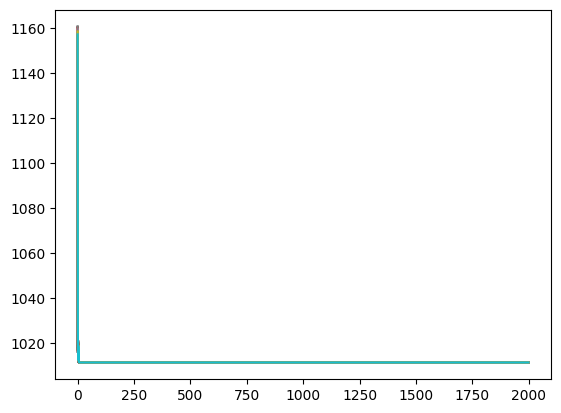

In [9]:
%matplotlib inline
plt.figure()
plt.plot(primal_residual)
plt.show()

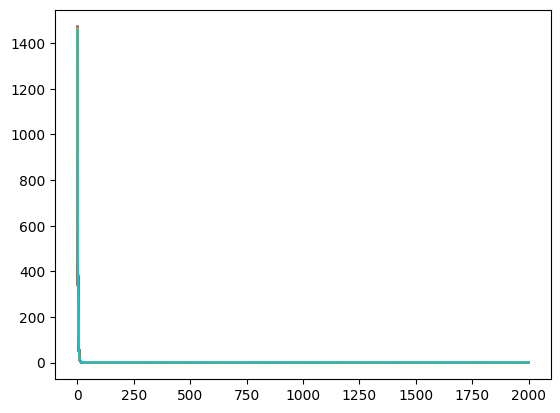

In [10]:
%matplotlib inline
plt.figure()
plt.plot(fixed_point_residual)
plt.show()

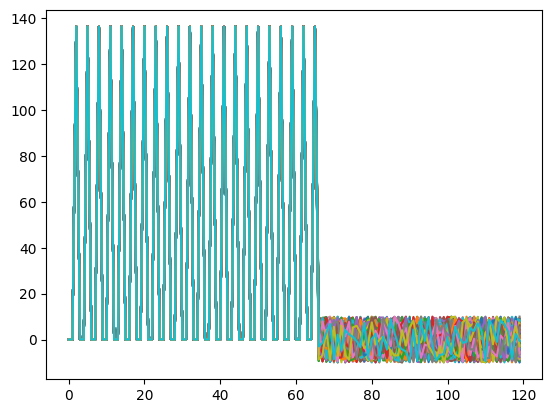

In [20]:
%matplotlib inline
plt.figure()
plt.plot(-xi_proj.T)
plt.show()